<a href="https://colab.research.google.com/github/IsraelAbebe/Personal-Projects-and-Exercises/blob/master/AIMS-Assignments/RL/AMMI_Multi_Armed_Bandits_Exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!git clone https://github.com/rlgammazero/mvarl_hands_on.git > /dev/null 2>&1

In [0]:
import sys
sys.path.insert(0, './mvarl_hands_on/exploration') 

In [0]:
import numpy as np
import arms
import matplotlib.pyplot as plt

# Multi-Armed Bandits
A MAB problem can be interpreted as a Markov Decision Process (MDP) with a single state and multiple actions (i.e., arms). At each round, the learning agent executes an action (i.e., arm) and observes a random realization of the reward associated to the arm. The goal is to find the arm with the highest mean reward

A MAB problem is defined by $N$ arms. Each arm $i$ has an associated reward distribution $\Lambda_i$ with mean $\mu_i$.

Let's define our first bandit problem

In [0]:
# Build your own bandit problem
arm1 = arms.ArmBernoulli(0.30)
arm2 = arms.ArmBernoulli(0.45)
arm3 = arms.ArmBernoulli(0.15)
arm4 = arms.ArmBernoulli(0.10)

MAB = [arm1, arm2, arm3, arm4]

In [75]:
arm1.mean,arm1.sample(),[i.sample() for i in MAB]

(0.3,
 array([False]),
 [array([False]), array([ True]), array([False]), array([False])])

In [76]:
nb_arms = len(MAB)
means = [el.mean for el in MAB]

# Display the means of your bandit (to find the best)
print('means: {}'.format(means))
mu_max = np.max(means)
print('best arm: {}'.format(mu_max))

# Parameters
nb_repetitions = 40
T = 500

means: [0.3, 0.45, 0.15, 0.1]
best arm: 0.45


# Regret
We evaluate exploration-exploitation algorithms based on the expected regret.
The **expected regret** measures the difference between executing the optimal arm $a^\star$ and following the learning agent:
$$R(T) = \mathbb{E}\Big[\sum_{t=1}^T \mu^\star - r_t \Big]$$

Algorithm and environment (MAB problem) are stochastic. We want to have meaningful results, thus we average over multiple runs.

# $\epsilon$-Greedy
This algorithm simply builds an estimate $\hat{\mu}_i$ of the mean reward of each arm and at each round it selects the action accorging to the following policy
$$a_t = \begin{cases}
\mathcal{U}(N) & \text{ with probability }~\epsilon\\
\arg\max_{i} \hat{\mu}_i & \text{ with probability }~1-\epsilon
\end{cases}$$

array([  502., 19498.])

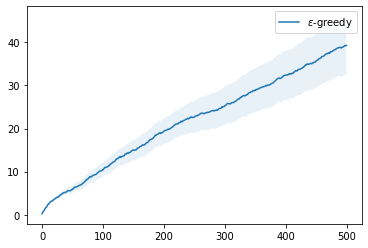

In [84]:
regret = np.zeros((nb_repetitions, T))
epsilon = 0.1


count = np.zeros(2)
for it in range(nb_repetitions):

    cumulative_reward = np.zeros((nb_arms,))
    N = np.zeros((nb_arms,))
    mu_hat = np.zeros((nb_arms,))

    for tt in range(T):
        #choose an arm
        x = np.random.rand()
        epsilon = 2/(tt+1)
        if x < epsilon:
            a = np.random.choice(nb_arms)
            count[0] += 1
        else:
            a = mu_hat.argmax()
            count[1] += 1

        r = MAB[a].sample()

        # update statsics mu_hat
        cumulative_reward[a] += r
        N[a] += 1
        mu_hat[a] = cumulative_reward[a]/N[a]

        regret[it,tt] = mu_max - r
    # to sample an arm/action:  MAB[arm].sample()
    
cum_regret = np.cumsum(regret, axis=1)
mean_regret = cum_regret.mean(axis=0)
std = cum_regret.std(axis=0) / np.sqrt(nb_repetitions)

plt.plot(mean_regret, label="$\epsilon$-greedy")
plt.fill_between(np.arange(T), mean_regret + std, mean_regret - std, alpha=0.1)
plt.legend()


# save current regret
regret_EPSGREEDY= mean_regret
std_EPSGREEDY= std
count

# The UCB1 algorithm

The UCB1 algorithm is proposed by [Auer et al](https://homes.di.unimi.it/~cesabian/Pubblicazioni/ml-02.pdf) for bandit instances with bounded rewards (in $[0,1]$ to fix the ideas). One can extend it to depend on some parameter $\alpha$: 

$$A_{t} = \underset{a}{\text{argmax}} \left[\hat{\mu}_a(t-1) + \sqrt{\frac{\alpha \log(t)}{N_a(t-1)}}\right],$$
where $\hat{\mu}_a(t)$ is the empirical mean of arm $a$ after $t$ rounds and $N_a(t)$ is the number of selections of arm $a$ till that time. 

UCB1 was originally proposed with $\alpha = 2$. Its analysis was later refined to allow for $\alpha > 1/2$ (see [here](http://sbubeck.com/Bubeckthesis.pdf) or [here](https://hal.archives-ouvertes.fr/hal-00738209/file/klucb.pdf)).

* Implement UCB($\alpha$).


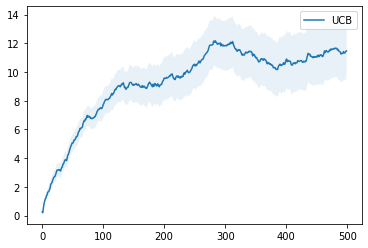

In [87]:
regret = np.zeros((nb_repetitions, T))
alpha = 0.5


count = np.zeros(2)
for it in range(nb_repetitions):

    cumulative_reward = np.zeros((nb_arms,))
    N = np.zeros((nb_arms,))
    mu_hat = np.zeros((nb_arms,))

    confidence_bound = np.inf*np.ones(nb_arms)

    for tt in range(T):
        # choose an arm
        # we need to compute mu_hat + confidence_bound and take argmax
        mu_hat = cumulative_reward/np.maximum(N,1)
        a = np.argmax(mu_hat+confidence_bound)

        r = MAB[a].sample()

        # update statsics mu_hat
        cumulative_reward[a] += r
        N[a] += 1
        mu_hat[a] = cumulative_reward[a]/N[a]

        regret[it,tt] = mu_max- r

        confidence_bound[a] = np.sqrt(alpha*np.log(tt+1)/N[a])
    # to sample an arm/action:  MAB[arm].sample()
    
cum_regret = np.cumsum(regret, axis=1)
mean_regret = cum_regret.mean(axis=0)
std = cum_regret.std(axis=0) / np.sqrt(nb_repetitions)

plt.plot(mean_regret, label="UCB")
plt.fill_between(np.arange(T), mean_regret + std, mean_regret - std, alpha=0.1)
plt.legend()


# save current regret
regret_UCB = mean_regret
std_UCB= std

Plot all the algorithms

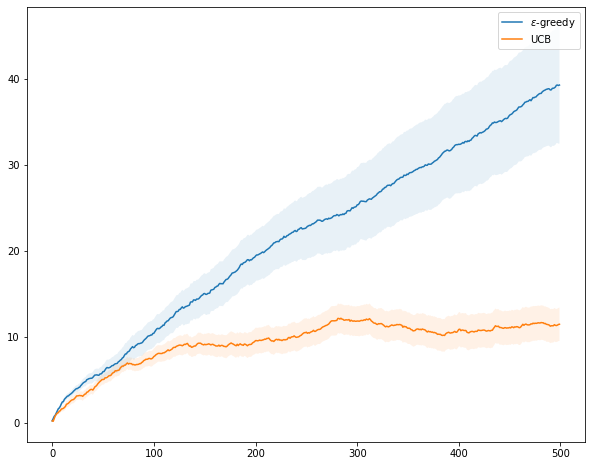

In [88]:
plt.figure(figsize=(10,8))
plt.plot(regret_EPSGREEDY, label="$\epsilon$-greedy")
plt.fill_between(np.arange(T), regret_EPSGREEDY + std_EPSGREEDY, regret_EPSGREEDY - std_EPSGREEDY, alpha=0.1)
plt.plot(regret_UCB, label="UCB")
plt.fill_between(np.arange(T), regret_UCB + std_UCB, regret_UCB - std_UCB, alpha=0.1)
plt.legend()